##Импортируем нужные модули

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

##Закачиваем датасет

In [66]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
dataset_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
dataset_dir = pathlib.Path(dataset_dir).with_suffix('')

Выводим кол-во. изображений в датасете

In [67]:
image_count = len(list(dataset_dir.glob("*/*.jpg")))
print(f"Всего изображений: {image_count}")

Всего изображений: 3670


## Создаем датасеты и кэшируем их

In [68]:
batch_size = 32
img_width = 180
img_height = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
	dataset_dir,
	validation_split=0.2,
	subset="training",
	seed=123,
	image_size=(img_height, img_width),
	batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
	dataset_dir,
	validation_split=0.2,
	subset="validation",
	seed=123,
	image_size=(img_height, img_width),
	batch_size=batch_size)

class_names = train_ds.class_names
print(f"Class names: {class_names}")

# cache
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Class names: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Создаем модель, компилируем её и выводим summary

In [69]:
# Создайм модель
num_classes = len(class_names)
model = Sequential([
	# т.к. у нас версия TF 2.6 локально
	layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

	# дальше везде одинаково
	layers.Conv2D(16, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(32, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(64, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Flatten(),
	layers.Dense(128, activation='relu'),
	layers.Dense(num_classes)
])

# Скомпилируем модель
model.compile(
	optimizer='adam',
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=['accuracy'])

# Распеспечать свотку
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 45, 45, 64)       

##Обучаем нейросеть и выводим графики точности


Epoch 1/10
92/92 [==============================] - 8s 34ms/step - loss: 1.3797 - accuracy: 0.4050 - val_loss: 1.1119 - val_accuracy: 0.5599
Epoch 2/10
92/92 [==============================] - 2s 19ms/step - loss: 1.0283 - accuracy: 0.5899 - val_loss: 1.0615 - val_accuracy: 0.5518
Epoch 3/10
92/92 [==============================] - 2s 22ms/step - loss: 0.8439 - accuracy: 0.6744 - val_loss: 0.8941 - val_accuracy: 0.6362
Epoch 4/10
92/92 [==============================] - 2s 20ms/step - loss: 0.6431 - accuracy: 0.7602 - val_loss: 0.9900 - val_accuracy: 0.6376
Epoch 5/10
92/92 [==============================] - 2s 20ms/step - loss: 0.4507 - accuracy: 0.8362 - val_loss: 0.9982 - val_accuracy: 0.6485
Epoch 6/10
92/92 [==============================] - 2s 19ms/step - loss: 0.2471 - accuracy: 0.9172 - val_loss: 1.2558 - val_accuracy: 0.6499
Epoch 7/10
92/92 [==============================] - 2s 20ms/step - loss: 0.1277 - accuracy: 0.9608 - val_loss: 1.3817 - val_accuracy: 0.6458
Epoch 8/10
92

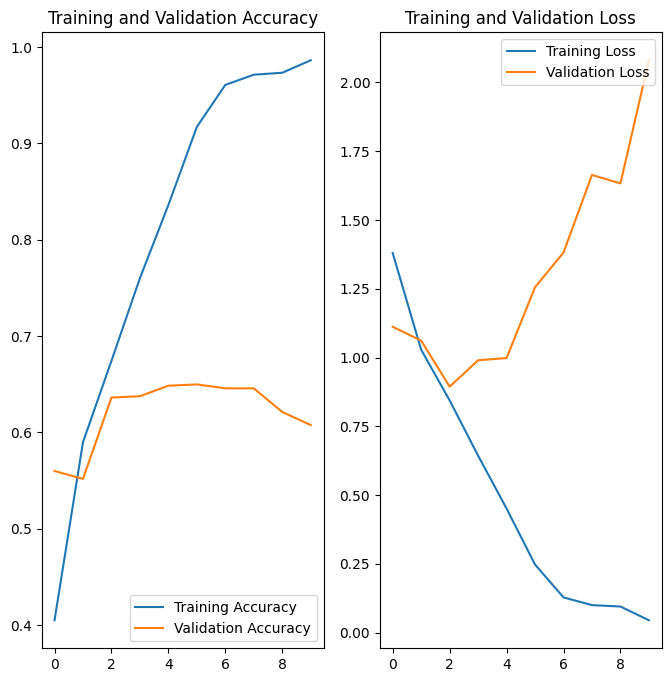

In [70]:
# Обучение
epochs = 10 # Кол-во эпох
history = model.fit(
	train_ds,
	validation_data=val_ds,
	epochs=epochs)

# Визуализация
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Решение проблемы переобучения.
##Добавляем аугментацию и регуляризацию (Dropout)

In [71]:
model = Sequential([
	# т.к. у нас версия TF 2.6 локально
	layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

	# увеличение
	layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
	layers.experimental.preprocessing.RandomRotation(0.1),
	layers.experimental.preprocessing.RandomZoom(0.1),
	layers.experimental.preprocessing.RandomContrast(0.2),

	# дальше везде одинаково
	layers.Conv2D(16, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(32, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(64, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	# регуляризация
	layers.Dropout(0.2),

	layers.Flatten(),
	layers.Dense(128, activation='relu'),
	layers.Dense(num_classes)
])

# скомпилируем модель
model.compile(
	optimizer='adam',
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=['accuracy'])

# Вывод сводки
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 random_flip_4 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_4 (RandomR  (None, 180, 180, 3)       0         
 otation)                                                        
                                                                 
 random_zoom_4 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 random_contrast_4 (RandomC  (None, 180, 180, 3)       0         
 ontrast)                                                        
                                                                 
 conv2d_27 (Conv2D)          (None, 180, 180, 16)     

##Повторно обучаем нейросеть с новыми слоями и увеличенным количеством эпох обучения

Epoch 1/22
92/92 [==============================] - 5s 31ms/step - loss: 1.2757 - accuracy: 0.4503 - val_loss: 1.1800 - val_accuracy: 0.5109
Epoch 2/22
92/92 [==============================] - 3s 31ms/step - loss: 1.0760 - accuracy: 0.5616 - val_loss: 0.9831 - val_accuracy: 0.5899
Epoch 3/22
92/92 [==============================] - 3s 29ms/step - loss: 0.9686 - accuracy: 0.6219 - val_loss: 0.9343 - val_accuracy: 0.6131
Epoch 4/22
92/92 [==============================] - 3s 28ms/step - loss: 0.9166 - accuracy: 0.6413 - val_loss: 0.9020 - val_accuracy: 0.6485
Epoch 5/22
92/92 [==============================] - 3s 30ms/step - loss: 0.8545 - accuracy: 0.6730 - val_loss: 0.8732 - val_accuracy: 0.6635
Epoch 6/22
92/92 [==============================] - 3s 28ms/step - loss: 0.7947 - accuracy: 0.6982 - val_loss: 0.8240 - val_accuracy: 0.6649
Epoch 7/22
92/92 [==============================] - 3s 28ms/step - loss: 0.7777 - accuracy: 0.7040 - val_loss: 0.7543 - val_accuracy: 0.6989
Epoch 8/22
92

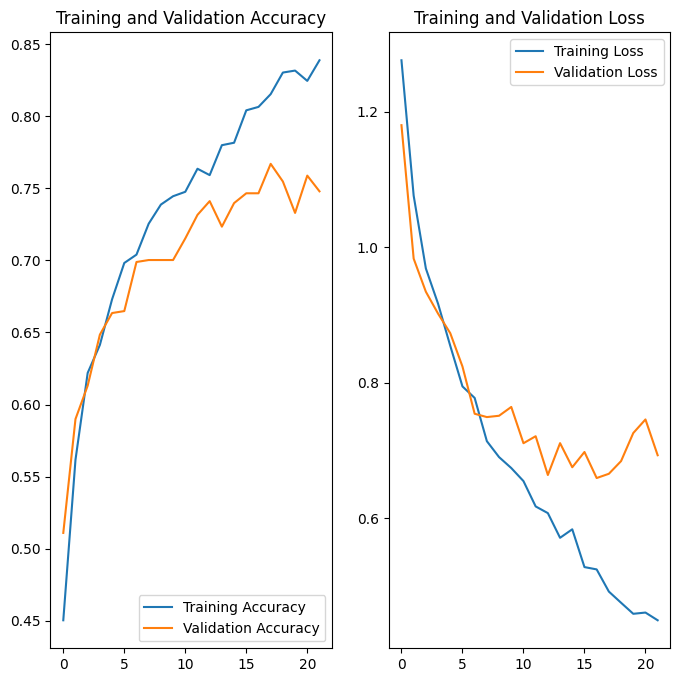

In [72]:
# обучение модели
epochs = 22 # количество эпох тренировки
history = model.fit(
	train_ds,
	validation_data=val_ds,
	epochs=epochs)

# Визуализация
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Делаем инференс на новом изображении

In [75]:
from IPython.display import Image
# Загружаем изображение
flower_url = "https://avatars.mds.yandex.net/get-images-cbir/1602909/ZKwWgynT5XJLnQjxNP772w7563/ocr"
flower_path = tf.keras.utils.get_file('Red_sunflower', origin=flower_url)

img = tf.keras.utils.load_img(
    flower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Делаем предсказание
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Распечатать вывод
print("На изображении скорее всего {} ({:.2f}% вероятность)".format(
	class_names[np.argmax(score)],
	100 * np.max(score)))

# Показываем изображение
Image(url=flower_url)

1/1 [==============================] - 0s 18ms/step
На изображении скорее всего sunflowers (99.91% вероятность)


##Экспорт файла модели (скачать себе на компьютер)

In [74]:
from google.colab import files

model_file_name = "my_flowers_model.h5"

# Сохраняем модель
model.save(model_file_name)

# Скачиваем модель
files.download(model_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>